## Sentiment analysis on Fine Food reviews¶


### Data import and preliminary analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>


In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

import numpy as np
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
import math
import pickle 

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from wordcloud import WordCloud, ImageColorGenerator



In [2]:
reviews = pd.read_csv(r'C:\Users\asus\Desktop\python\AI notebook\amazon_Reviews.csv',nrows = 50000)
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
reviews.shape

(50000, 10)

## Data cleaning

In [4]:
reviews.info()
reviews.dropna(inplace=True)
print('Duplicated values: '+ str(reviews.duplicated().value_counts()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      50000 non-null  int64 
 1   ProductId               50000 non-null  object
 2   UserId                  50000 non-null  object
 3   ProfileName             49997 non-null  object
 4   HelpfulnessNumerator    50000 non-null  int64 
 5   HelpfulnessDenominator  50000 non-null  int64 
 6   Score                   50000 non-null  int64 
 7   Time                    50000 non-null  int64 
 8   Summary                 49998 non-null  object
 9   Text                    50000 non-null  object
dtypes: int64(5), object(5)
memory usage: 3.8+ MB
Duplicated values: False    49995
dtype: int64


In [5]:
reviews['sentiment'] = reviews['Score'].apply(lambda x: 'positive' if x > 3 else 'negative' if x < 3 else 'neutral')

In [6]:
reviews['Text'] = reviews['Text'].str.replace('\d+', '') # for digits
reviews['Text'] = reviews['Text'].str.replace(r'(\b\w{1,2}\b)', '') # for words
reviews['Text'] = reviews['Text'].str.replace('[^\w\s]', '') # for punctuation 
reviews['Summary'] = reviews['Summary'].str.replace('\d+', '') # for digits
reviews['Summary'] = reviews['Summary'].str.replace(r'(\b\w{1,2}\b)', '') # for words
reviews['Summary'] = reviews['Summary'].str.replace('[^\w\s]', '') # for punctuation 

In [7]:
reviews.sentiment.value_counts()


positive    38417
negative     7531
neutral      4047
Name: sentiment, dtype: int64

In [8]:
reviews.sentiment.value_counts(normalize=True)

positive    0.768417
negative    0.150635
neutral     0.080948
Name: sentiment, dtype: float64

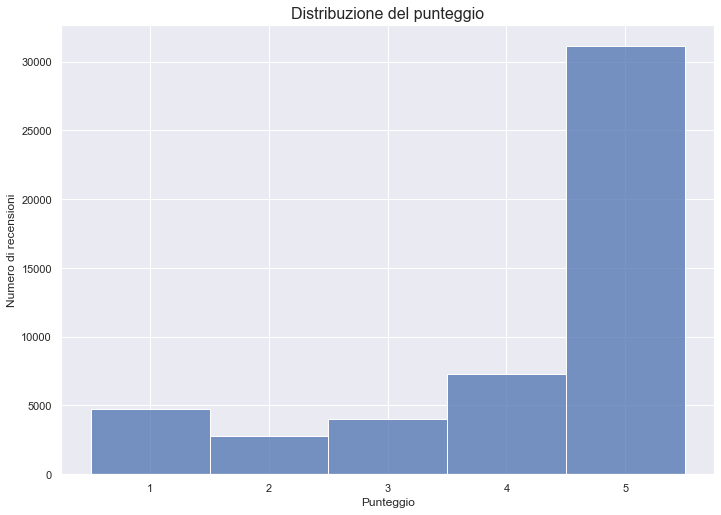

In [9]:
ax = sns.histplot(reviews, x="Score", discrete=True)
ax.set_xlabel( "Punteggio" , size = 12 )
ax.set_ylabel("Numero di recensioni")
  
ax.set_title("Distribuzione del punteggio" , size = 16 )

plt.show()

## Word clouds¶

In [10]:
# Create stopword list:
stop_words = ENGLISH_STOP_WORDS.union(["br","href", 'http', 'just', 'amazon', 'product','time','year', 'tried','I\'ve'])

## General words

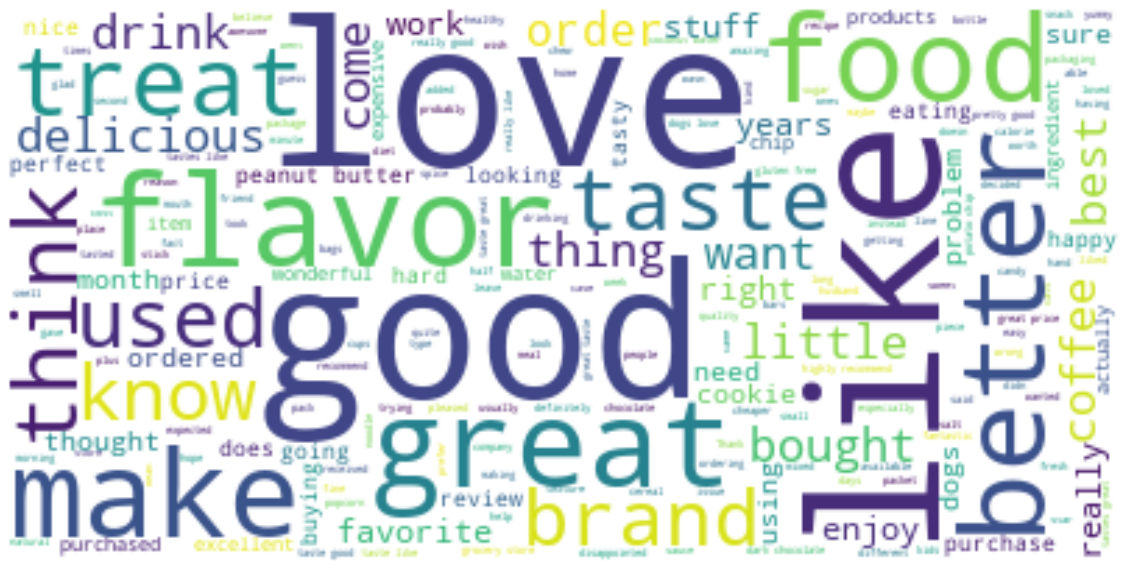

In [11]:
text = " ".join(review for review in reviews.Text) + " ".join(review for review in reviews.Summary)

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white", stopwords=stop_words, min_word_length=4, collocation_threshold=10).generate(text)

# Display the generated image:
plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

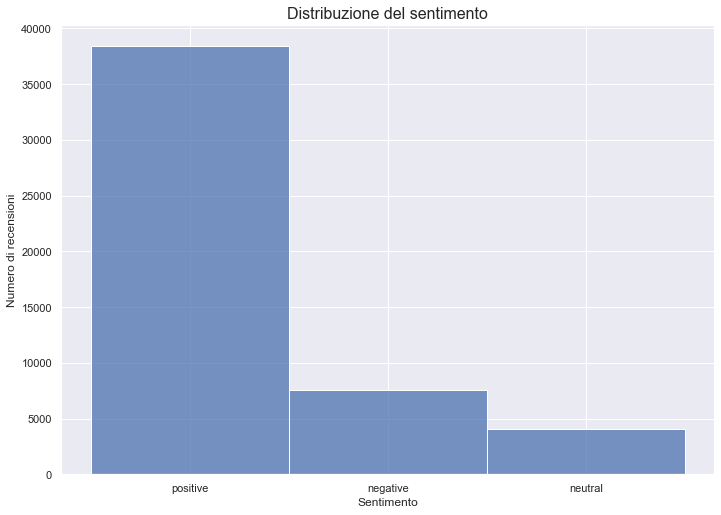

In [12]:
ax = sns.histplot(reviews, x='sentiment', discrete=True)

ax.set_xlabel( "Sentimento" , size = 12 )
ax.set_ylabel("Numero di recensioni")
  
ax.set_title("Distribuzione del sentimento" , size = 16 )

plt.show()

## Wordcloud for positive sentiment

In [13]:
reviews_negative = reviews[reviews['sentiment'] == 'negative']
reviews_positive = reviews[reviews['sentiment'] == 'positive']
reviews_neutral = reviews[reviews['sentiment'] == 'neutral']



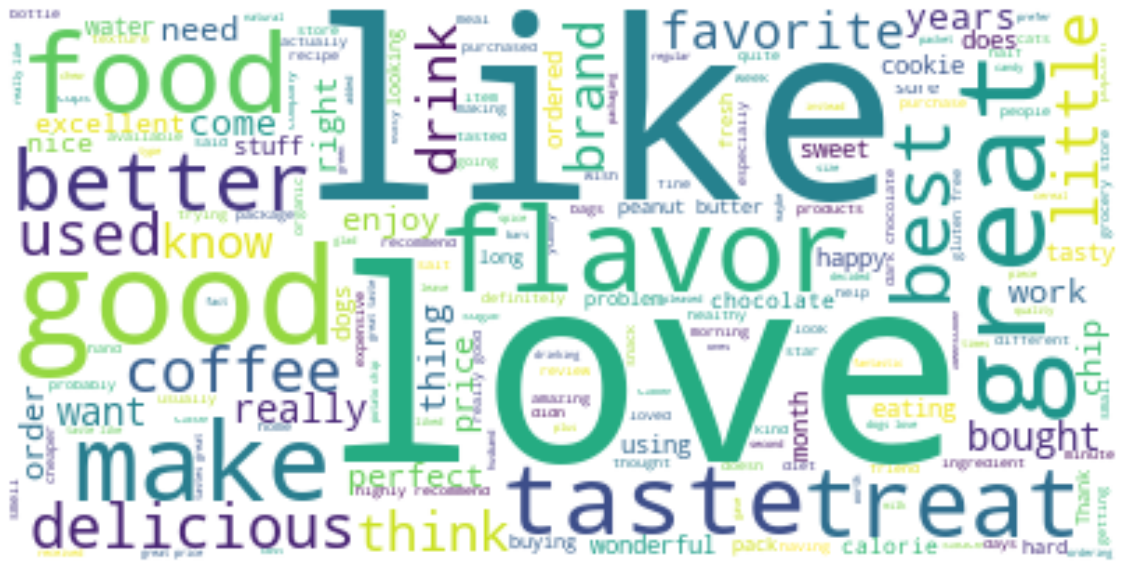

In [14]:
text_positive = " ".join(review for review in reviews_positive.Text) + " ".join(review for review in reviews_positive.Summary)

wordcloud = WordCloud(background_color="white", stopwords=stop_words, min_word_length=4, collocation_threshold=15).generate(text_positive)

plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Wordcloud for neutral sentiment

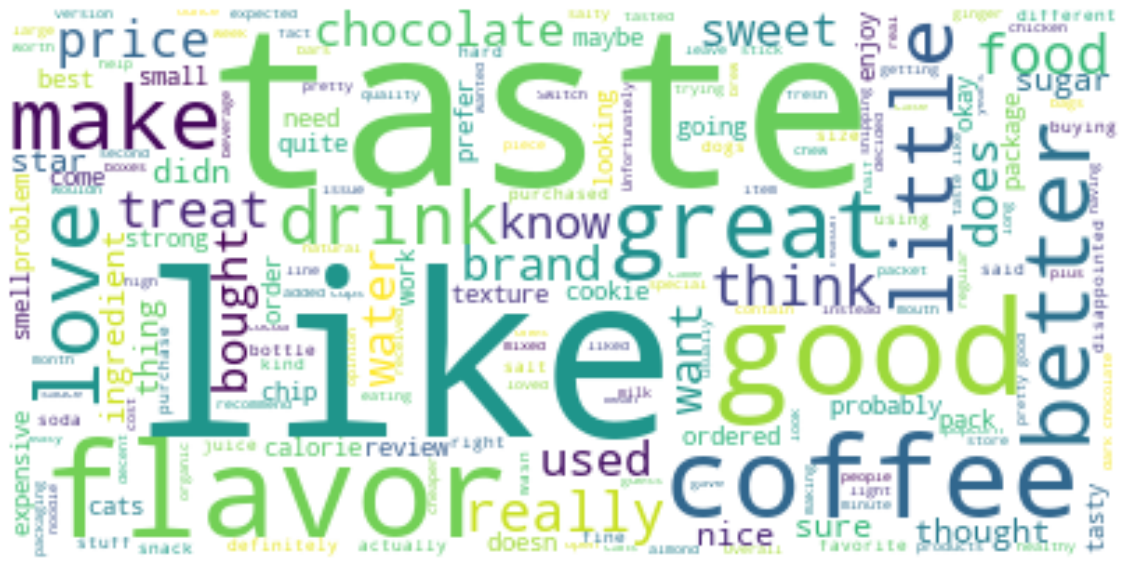

In [15]:
text_neutral = " ".join(review for review in reviews_neutral.Text) + " ".join(review for review in reviews_neutral.Summary)

wordcloud = WordCloud(background_color="white", stopwords=stop_words, min_word_length=4, collocation_threshold=15).generate(text_neutral)

plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Wordcloud for negative sentiment

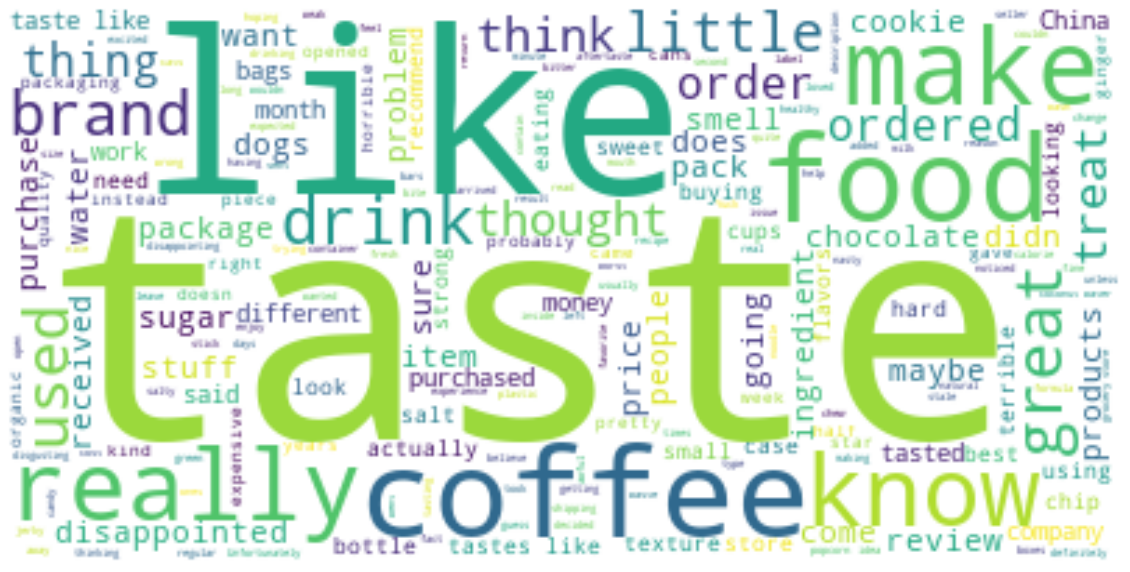

In [16]:
text_negative = " ".join(review for review in reviews_negative.Text) + " ".join(review for review in reviews_negative.Summary)

stop_words_neg = stop_words.union(['good','flavor','bought','better','love']) #added because present in form of negation

wordcloud = WordCloud(background_color="white", stopwords=stop_words_neg, min_word_length=4, collocation_threshold=15).generate(text_negative)

plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Looking for unique words for each sentiment



Now I am going to look at the tri-grams that are specific of each sentiment

In [17]:
sentiment = reviews.sentiment.unique()

#create a list of responses for each sentiment using a list comprehension
corpus = [' '.join(reviews[(reviews.sentiment==sent)].Text.tolist()) for sent in sentiment]

cv=CountVectorizer( stop_words=stop_words, ngram_range=(1, 3))

# fit transform text and create a dataframe bag of words with the result
X = cv.fit_transform(corpus)
X = X.toarray()

bow=pd.DataFrame(X, columns = cv.get_feature_names())
bow.index=sentiment

#build an empty dataframe
t_bow_df=pd.DataFrame()

# By sentiment, divide the number of times a word is said, 
# by the total number of times they've said all the words that they have said (frequency)
bow_transformed = bow.apply(lambda x: (x+1)/ (bow.loc[x.name].sum()+1), axis=1) 

for sent in sentiment:
    feat_s = bow[bow.index != sent].sum()+1 #sum all the times each word was said excluding the sent
    feat_s_all = np.sum(bow[bow.index != sent].sum()) # all the total words that were said, excluding the sent
    tot = feat_s / feat_s_all #find the frequency of words said among other sent
    row = bow_transformed.loc[sent] / tot #divide the candidate's array of frequency of words by all other sent' frequency
    row = pd.DataFrame(row).T #create a df, and transform
    results = row.apply(lambda x: math.log(x,2)) #take the log of each frequency
    
    t_bow_df = pd.concat([t_bow_df, pd.DataFrame([results], index=[sent])]) #append 
    


C:\Users\asus\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ve'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [18]:
t_bow_df.sort_values(by ='positive', axis=1, ascending=False).iloc[:,:15]

,bowel tolerance,hooked,satisfies,powdered peanut butter,powdered peanut,recommend highly,goes great,simply best,loves great,thanks great,wine gums,tea favorite,allowance rda,right door,causes diarrhea
positive,4.742443,4.677737,4.538909,4.425252,4.425252,4.352496,4.327405,4.327405,4.301870,4.275875,4.249403,4.222436,4.194955,4.194955,4.194955
negative,-3.911111,-4.112745,-3.707578,-3.593921,-3.593921,-3.521165,-3.496074,-3.496074,-3.470538,-3.444543,-3.418071,-3.391104,-3.363623,-3.363623,-3.363623
neutral,-2.999915,-4.533347,-2.796381,-2.682724,-2.682724,-2.609968,-2.584877,-2.584877,-2.559342,-2.533347,-2.506875,-2.479907,-2.452427,-2.452427,-2.452427


In [19]:
t_bow_df.sort_values(by ='neutral', axis=1, ascending=False).iloc[:,:15]

,tompson,tompson morgan,word word,monophosphate,podz,word word word,nitrites,wrong wolfgang puck,wrong wolfgang,luck chen,chen,decaf bought,fish varieties,food study,review chili
positive,-5.205925,-5.205925,-5.090447,-4.964916,-4.964916,-4.827413,-4.675410,-4.675410,-4.675410,-4.675410,-4.675410,-4.505485,-4.505485,-4.505485,-4.505485
negative,-1.363623,-1.363623,-1.248146,-1.122615,-1.122615,-0.985112,-0.833109,-0.833109,-0.833109,-0.833109,-0.833109,-0.663184,-0.663184,-0.663184,-0.663184
neutral,6.948453,6.948453,6.832975,6.707445,6.707445,6.569941,6.417938,6.417938,6.417938,6.417938,6.417938,6.248013,6.248013,6.248013,6.248013


In [20]:
t_bow_df.sort_values(by ='negative', axis=1, ascending=False).iloc[:,:15]

,threw rest,tasty eats,don waste money,alive aware,going trash,greta,extremely disappointed,dogs died,zero stars,stay far,complete waste money,nastiest,jerky treats china,rest away,tartaric acid
positive,-5.897802,-5.753412,-6.634768,-5.505485,-5.412375,-5.412375,-6.412375,-5.312840,-5.312840,-5.312840,-5.312840,-5.312840,-5.205925,-5.149341,-5.090447
negative,6.729134,6.584744,6.424279,6.336816,6.243707,6.243707,6.194797,6.144171,6.144171,6.144171,6.144171,6.144171,6.037256,5.980673,5.921779
neutral,-1.144304,-0.999915,-1.275549,-0.751987,-0.658878,-0.658878,-0.609968,-0.559342,-1.609968,-0.559342,-0.559342,-0.559342,-0.452427,-1.452427,-0.336950


## Building the model

In [21]:
X_train, X_test, y_train, y_test = train_test_split(reviews.Text, reviews.sentiment, train_size=0.80,random_state = 42)

In [22]:
vectorizer = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)

In [23]:
train_df = pd.DataFrame(X_train,columns= ['Text'])
train_df.to_csv('final_reviews__.csv')

In [24]:
train_df['Text']

27424    The Ocean Spray  the  drink mix  low calorie a...
32598    The sugar bees came exactly  described and wel...
41717     dog has  take   pills twice  day  Before  tri...
18144    Let  honest Nothing will compare  real peanut ...
49110    Everyone  the party really loved this  was fun...
                               ...                        
11284     floored  the negative reviews   started eatin...
44736     was almost  love  first bite  the perfectly r...
38160     have the Beaba baby food maker and two  the t...
860      The chocolate  the stick was all melted and al...
15795    Why  this  expensive  amazon   can buy  locall...
Name: Text, Length: 39996, dtype: object

In [25]:
X_train.shape

(39996,)

In [26]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [27]:
X_train.shape

(39996, 43965)

### Parameters tuning with hyperopt

In [ ]:
space = {#'criterion': hp.choice('criterion', ['gini']),
        'max_depth': hp.quniform('max_depth', 60, 120, 20),
        'n_estimators' :hp.choice('n_estimators', [150, 200, 250]),
        #'class_weight': hp.choice('class_weight', [{'positive':1,'negative':4,'neutral':8}, {'positive':1,'negative':5,'neutral':10}])
         'class_weight': hp.choice('class_weight',['balanced', 'balanced_subsample'])
    }
 
def objective(space):
    model = RandomForestClassifier(criterion = 'gini', 
                                   max_depth = space['max_depth'],
                                   n_estimators = space['n_estimators'],
                                   class_weight = space['class_weight']
                                 )
    
    accuracy = cross_val_score(model, X_train, y_train, cv = 5, n_jobs=-1).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }
    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 7,
            trials= trials)
print(best)  


In [28]:
print(X_train.get_shape())

(39996, 43965)


In [29]:
train_df.shape

(39996, 1)

## Model training

In [31]:
trainedforest = RandomForestClassifier(criterion = 'gini',
                                       max_depth = 50,  
                                       n_estimators = 100,
                                       class_weight = 'balanced',
                                       oob_score = True,
                                       n_jobs = -1
                                      ).fit(X_train,y_train)


predictionforest = trainedforest.predict(X_test)

matrix = confusion_matrix(y_test,predictionforest)

print(matrix)
print(classification_report(y_test,predictionforest))
acc5 = accuracy_score(y_test,predictionforest)
print('overall accuracy: ' + str(acc5))

[[ 873   17  592]
 [ 150   91  600]
 [ 240   28 7408]]
              precision    recall  f1-score   support

    negative       0.69      0.59      0.64      1482
     neutral       0.67      0.11      0.19       841
    positive       0.86      0.97      0.91      7676

    accuracy                           0.84      9999
   macro avg       0.74      0.55      0.58      9999
weighted avg       0.82      0.84      0.81      9999

overall accuracy: 0.8372837283728373


In [73]:
filename = 'final_last_model.sav'
pickle.dump(trainedforest,open(filename,'wb'))

## confusion matrix

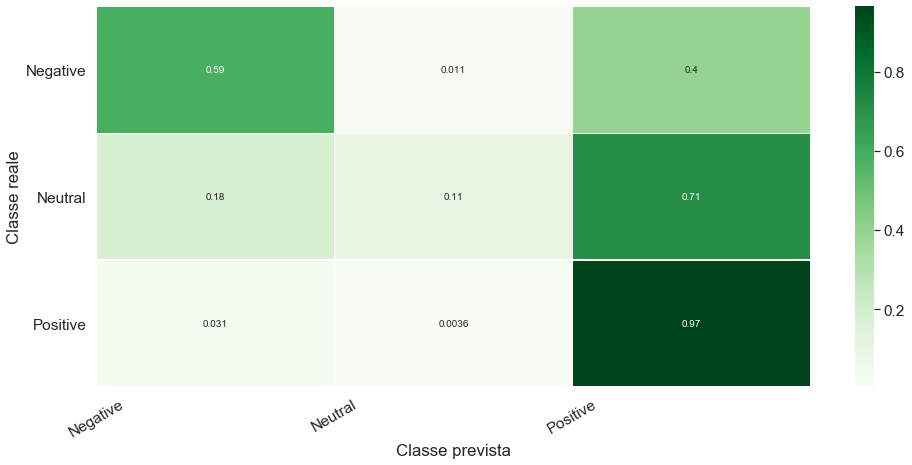

In [35]:
#matrix = confusion_matrix(predictions_clf,y_test) #da commentare se la storia del coso automatico funziona
# Get and reshape confusion matrix data
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Negative', 'Neutral', 'Positive']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=30)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Classe prevista')
plt.ylabel('Classe reale')
#plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [36]:
#X_train, X_test, y_train, y_test = train_test_split(reviews.Text, reviews.sentiment, train_size=0.80)
vectorizer = CountVectorizer(stop_words=ENGLISH_STOP_WORDS)
X_train = vectorizer.fit_transform(train_df['Text'])

X_test = vectorizer.transform(['Watch your prices with this  While the assortment was good and  did get this   gold box purchase the price for this was  less  Target'])

filename ='C:\\Users\\asus\\Desktop\\ML_Project\\New_folder\\final_last_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

predictionforest = loaded_model.predict(X_test)
print(predictionforest)


['neutral']
